## Detecção de Incêndios Florestais utilizando Redes Neurais Convolucionais

<img src="https://media2.giphy.com/media/RuhIAu5P0LO7u/giphy.gif?cid=ecf05e47qr2jh7mh57dfnvvct3bdqwxj2y4cb5tat96kufvr&rid=giphy.gif&ct=g" width="480" align="center">


#### Informações sobre o Dataset:

- Os dados foram coletados para treinar um modelo para distinguir entre as imagens que contêm fogo (imagens de fogo) e imagens regulares (imagens que não são de fogo), então todo o problema é de classificação binária.


- Os dados são divididos em 2 pastas, a pasta fireimages contém 755 imagens de fogo ao ar livre, algumas delas contêm fumaça, a outra não são imagens de fogo que contém 244 imagens da natureza (por exemplo: florestas, árvores, gramas, rios, pessoas, lagos, animais, estradas e cachoeiras).


- Observação: os dados estão distorcidos, o que significa que as 2 classes (pastas) não têm um número igual de amostras, então certifique-se de ter um conjunto de validação com um número igual de imagens por classe (por exemplo: 40 imagens de ambas classes de fogo e não fogo).

O dataset se encontra na plataforma ``Kaggle`` no link abaixo:

- https://www.kaggle.com/phylake1337/fire-dataset

## 1. Importações das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

## 2. Criando o Dataframe

In [2]:
dir_ = Path('../input/fire-dataset/fire_dataset')
png_filepaths = list(dir_.glob(r'**/*.png'))

In [3]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], png_filepaths))

In [4]:
# Caminhos & labels...
filepaths = pd.Series(png_filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name = 'Label')

# Concatenando...
df = pd.concat([filepaths, labels], axis=1)

# Mudando os nomes...
df['Label'].replace({"non_fire_images":"nofire","fire_images":"fire"}, inplace=True)

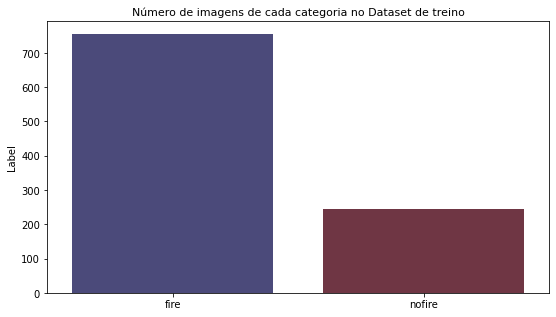

In [5]:
# Visualizando os dados do dataset em um barplot
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc, palette = "icefire")
plt.title("Número de imagens de cada categoria no Dataset de treino", fontsize = 11)
plt.show()

Podemos observar que o nosso dataset de imagens está desbalanceado, assim como estava na descrição do dataset no kaggle.

In [6]:
# Misturando o dataframe e resetando o index
df = df.sample(frac = 1, random_state = 83).reset_index(drop = True)

# Resultado
df.head()

,File,Label
0,../input/fire-dataset/fire_dataset/non_fire_im...,nofire
1,../input/fire-dataset/fire_dataset/fire_images...,fire
2,../input/fire-dataset/fire_dataset/fire_images...,fire
3,../input/fire-dataset/fire_dataset/non_fire_im...,nofire
4,../input/fire-dataset/fire_dataset/fire_images...,fire


Nós precisamos remover a imagem 'non_fire.189.png' pois ela está com formato incompatível

In [7]:
png_error = '../input/fire-dataset/fire_dataset/non_fire_images/non_fire.189.png'
df = df.loc[~(df.loc[:, 'Label'] == png_error), :]

## 3. Dividindo em conjuntos de treinamento e teste

Agora precisamos converter nossos dados em conjuntos de treinamento e teste. Usaremos 90% das imagens como nossos dados de treinamento e testaremos nosso modelo nos 10% restantes com a função ``train_test_split`` do Scikit-learn.

In [8]:
train_df, test_df = train_test_split(df, train_size = 0.9, random_state = 86)

display(train_df.head())

test_df.head()

,File,Label
986,../input/fire-dataset/fire_dataset/fire_images...,fire
333,../input/fire-dataset/fire_dataset/fire_images...,fire
462,../input/fire-dataset/fire_dataset/non_fire_im...,nofire
435,../input/fire-dataset/fire_dataset/fire_images...,fire
446,../input/fire-dataset/fire_dataset/fire_images...,fire


,File,Label
414,../input/fire-dataset/fire_dataset/non_fire_im...,nofire
757,../input/fire-dataset/fire_dataset/fire_images...,fire
393,../input/fire-dataset/fire_dataset/fire_images...,fire
912,../input/fire-dataset/fire_dataset/fire_images...,fire
686,../input/fire-dataset/fire_dataset/fire_images...,fire


In [9]:
# Visualizando os dados em ambos datasets
print('Dataset de treinamento:')

print(f'Número de imagens: {train_df.shape[0]}')

print(f'Número de imagens com fogo: {train_df["Label"].value_counts()[0]}')
print(f'Número de imagens sem fogo: {train_df["Label"].value_counts()[1]}\n')
      
print('Dataset de teste:')
      
print(f'Número de imagens no dataset de teste: {test_df.shape[0]}')
print(f'Número de imagens com fogo: {test_df["Label"].value_counts()[0]}')
print(f'Número de imagens sem fogo: {test_df["Label"].value_counts()[1]}')

Dataset de treinamento:
Número de imagens: 899
Número de imagens com fogo: 684
Número de imagens sem fogo: 215

Dataset de teste:
Número de imagens no dataset de teste: 100
Número de imagens com fogo: 71
Número de imagens sem fogo: 29


In [10]:
# convertendo a Label para formato númerico para teste posteriormente
LE = LabelEncoder()

y_test = LE.fit_transform(test_df["Label"])

## 4. Observando as imagens

In [11]:
plt.style.use("dark_background")

Text(0.5, 1.0, 'fire')

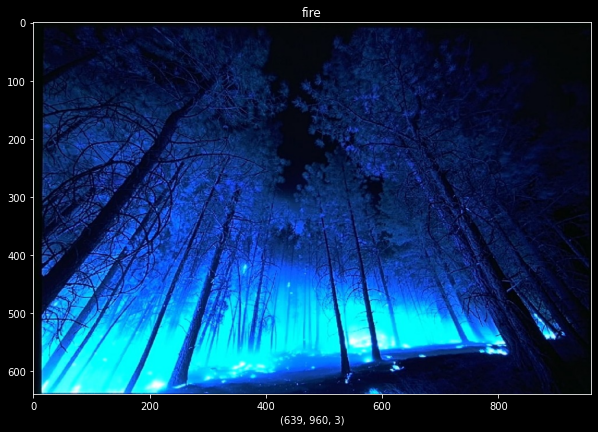

In [12]:
# Observando as imagens do dataset de treino (fire)
figure = plt.figure(figsize=(10, 10))
x = cv2.imread(train_df["File"][986])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_df["Label"][986])

Text(0.5, 1.0, 'nofire')

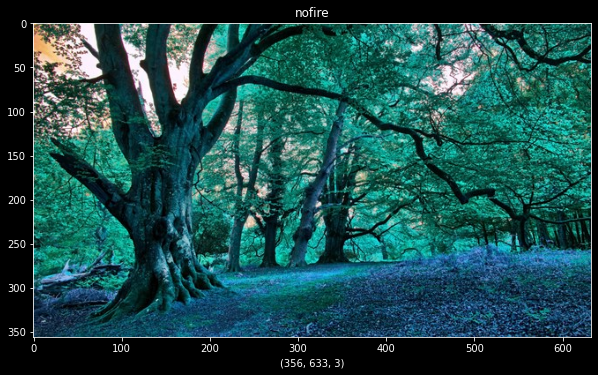

In [13]:
# Observando as imagens do dataset de treino (nofire)
figure = plt.figure(figsize=(10,10))
x = cv2.imread(train_df["File"][910])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_df["Label"][910])

Text(0.5, 1.0, 'fire')

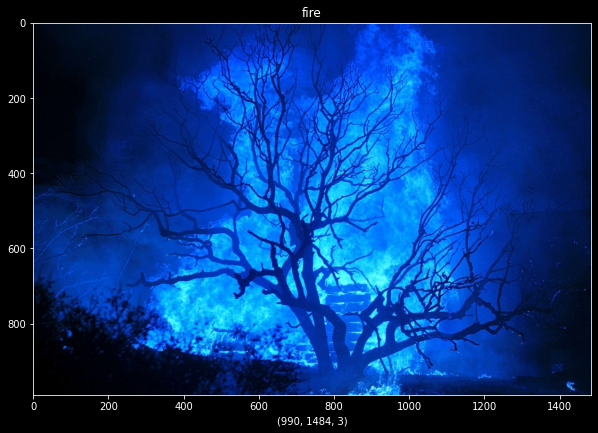

In [14]:
# Observando as imagens do dataset de teste (fire)
figure = plt.figure(figsize = (10,10))
x = cv2.imread(test_df["File"][686])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(test_df["Label"][686])

Text(0.5, 1.0, 'nofire')

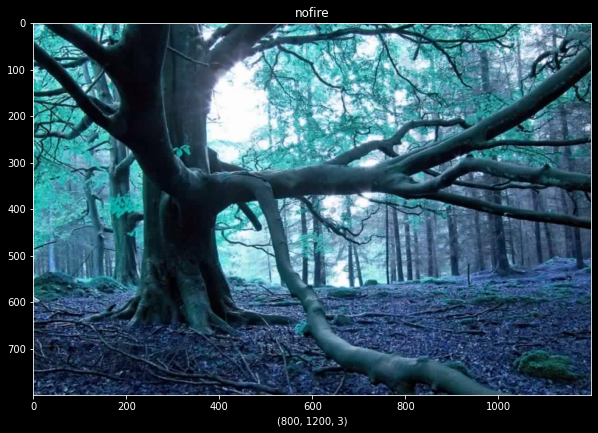

In [15]:
# Observando as imagens do dataset de teste (nofire)
figure = plt.figure(figsize=(10,10))
x = cv2.imread(test_df["File"][978])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(test_df["Label"][978])

## 5. Pré-processamento das imagens
Nesta parte iremos fazer o pré-processamento das imagens da base de dados de treinamento usando o [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class), para a base de dados de teste iremos apenas fazer a normalização dos dados

Paramêtros do ``ImageDataGenerator``:

    rescale - Transforma o tamanho da imagem (normalização dos dados)
    shear_range - Transformações geometricas aleatórias
    zoom_range - Imagens que serão aplicadas o zoom
    brightness_range - Grau da mudança do brilho (tupla ou lista)
    rotation_range - grau da rotação da imagem
    width_shift_range - Faixa da mudança da altura da imagem
    height_shift_range - Faixa da mudança da largura da imagem
    horizontal_flip - Girar as imagens horizontalmente
    vertical_flip - Girar as imagens verticalmente
    validation_split - Imagens que ficaram reservadas para validação (0-1)

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

## 6. Diretório das imagens de treinamento, validação e teste

Aqui fazemos a divisão das bases de imagens para treinamento, validação e teste do modelo, para isso usamos o [flow_from_dataframe](https://keras.io/api/preprocessing/image/#flowfromdataframe-method)

Paramêtros do ``flow_from_directory``:

    dataframe - Dataframe contendo o diretório da imagem
    x_col - Nome da coluna contendo o diretório das imagens
    y_col - Nome da coluna contendo oque queremos prever
    target_size - tamanho das imagens (lembrando que deve ser do mesmo tamanho da camada de entrada)
    color_mode - Padrão de cores RGB
    class_mode - modo da classe binário (Fire/No Fire)
    batch_size - tamanho do batch
    shuffle - Embaralhar os dados 
    seed - semente aleatória opcional para o shuffle
    subset - Subset dos dados sendo training e validation (apenas usado caso use validation_split no ImageDataGenerator) 

In [17]:
print("Preparando o dataset de treino...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "File",
    y_col = "Label",
    target_size = (250, 250),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 1,
    subset = "training")

print("Preparando o dataset de validação...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "File",
    y_col = "Label",
    target_size = (250, 250),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 1,
    subset = "validation")

print("Preparando o dataset de teste...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "File",
    y_col = "Label",
    target_size = (250, 250),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Geradores de dados prontos!')

Preparando o dataset de treino...
Found 810 validated image filenames belonging to 2 classes.
Preparando o dataset de validação...
Found 89 validated image filenames belonging to 2 classes.
Preparando o dataset de teste...
Found 100 validated image filenames belonging to 2 classes.
Geradores de dados prontos!


## 7. Construção do modelo (ConvNet)

CNNs são um tipo específico de rede neural artificial bastante eficaz para classificação de imagens pois são capazes de levar em consideração a coerência espacial da imagem, ou seja, que pixels próximos uns dos outros estão frequentemente relacionados.

A construção de uma CNN começa com a especificação do tipo de modelo. Em nosso caso, usaremos um modelo ``Sequential``.

<p><img src = "https://i.ibb.co/0jWhFsW/ConvNet.png" alt></p>

###### Etapa 1 - Convolution
Detector de Características e Mapa de Características

    Número de filtros (32)
    Dimensões do detector de características (3, 3)
    Definição da altura/largura e canais RGB (250, 250, 3)
    Função de ativação para retirar os valores negativos da imagem - 'relu'
    Aceleração do processamento - BatchNormalization

In [18]:
CNN = Sequential()

CNN.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

###### Etapa 2 - Max Pooling
Redução do tamanho da imagem focando nas caracteristicas mais importantes

    Definição da matriz com o total de 4 pixels (2, 2)

In [19]:
CNN.add(MaxPooling2D(pool_size = (2, 2)))

###### Etapa 3 - Camadas ocultas

In [20]:
CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [21]:
CNN.add(Conv2D(64, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.2))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [22]:
CNN.add(Conv2D(128, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

###### Etapa 4 - Flattening
    
    Transformação da matriz para um vetor para entrar na camada da Rede Neural Artificial

In [23]:
CNN.add(Flatten())

###### Etapa 5 - Redes Neurais Densas

Parâmetros da ``RNA``:

    Dense - Todos os neurônios conectados
    units - Quantidade de neurônios que fazem parte da camada oculta
    activation - Função de ativação que será inserida
    Dropout - é usado para diminuir a chance de overfitting (40% dos neurônios de entrada são zerados)

Parâmetros do ``EarlyStopping``:

    monitor - Métrica que irá ser monitorada
    patience - Número de épocas sem melhoras no modelo, após estas épocas o treinamento é interrompido
    restore_best_weights - Restaura os melhores pesos caso o treinamento seja interrompido

In [24]:
# Camada de entrada
CNN.add(Dense(units = 256, activation = 'relu'))
CNN.add(Dropout(0.4))
# Camada de saida (classificação binária)
CNN.add(Dense(units = 1, activation = 'sigmoid'))
# Callbacks
callbacks = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 20, restore_best_weights = True)]

print(CNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 59, 59, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)        0

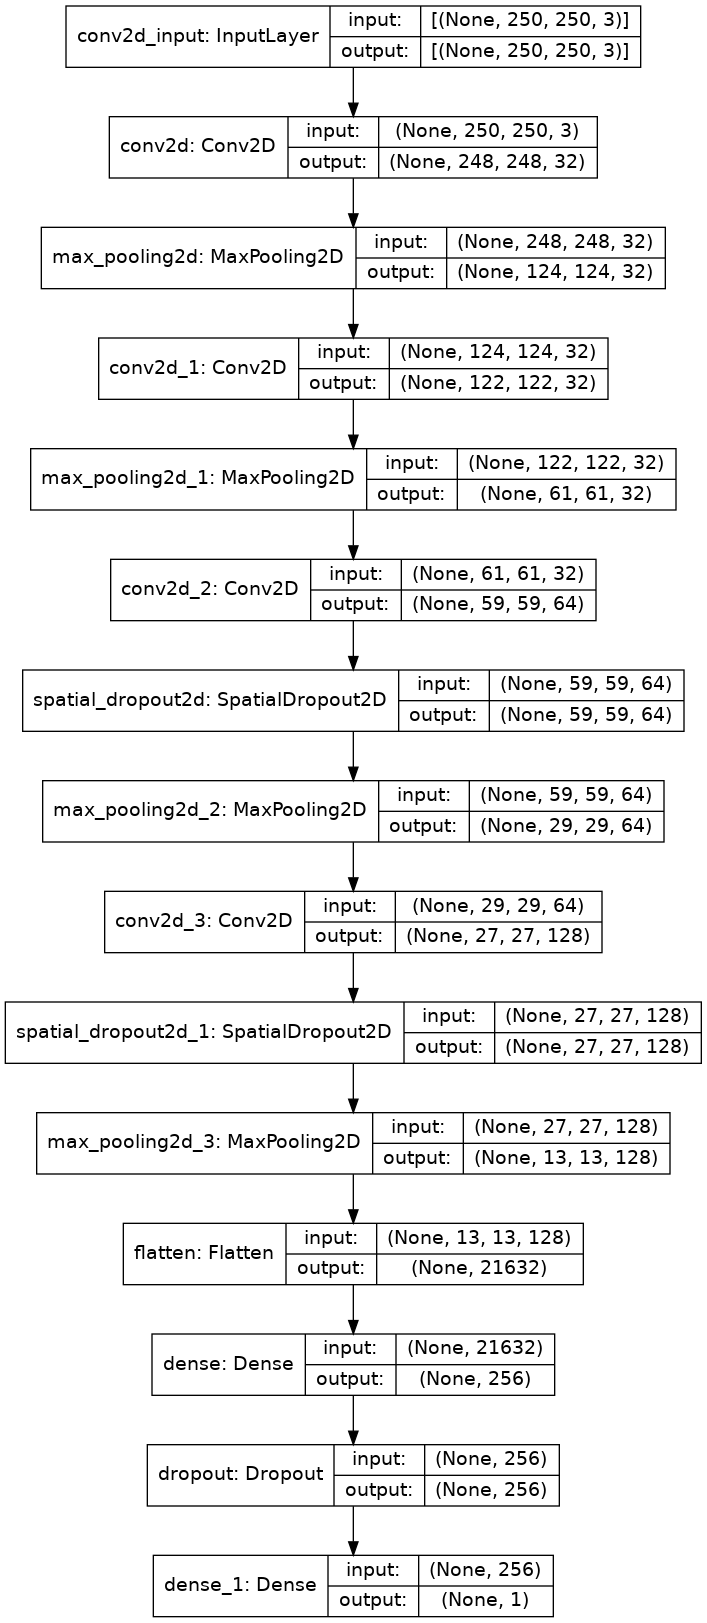

In [25]:
plot_model(CNN, to_file='CNN_model.png', show_layer_names = True , show_shapes = True)

###### Etapa 6 - Compilação e treinamento do modelo

Agora que especificamos a arquitetura do modelo, iremos compilar o modelo para treinamento. Para isso, precisamos especificar a função de perda (o que estamos tentando minimizar), o otimizador (como queremos fazer para minimizar a perda) e a métrica (como julgaremos o desempenho do modelo). Em seguida, chamaremos .fit para iniciar o treinamento do processo.

Parâmetros do ``compile``:

    optimizer - descida do gradiente e descida do gradiente estocástica
    loss - Função de perda (binary_crossentropy pois só há uma saída)
    metrics - Métrica de avaliação (obs - pode ser colocado mais de um)

Paramêtros do ``fit``:

    train_data - base de dados de treinamento
    epochs - número de épocas
    validation_data - base de dados de teste
    callbacks - Utilização do EarlyStopping
    validation_steps - número de imagens para teste

In [26]:
# Compilação
CNN.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Inicio da contagem do tempo
start = dt.datetime.now()

# Treinamento
CNN_model = CNN.fit(training_set, epochs = 100, validation_data = validation_set, callbacks = callbacks)

# Fim da Contagem do tempo
end = dt.datetime.now()
time_CNN = end - start
print ('\nTempo de treinamento e validação: ', time_CNN)

Epoch 1/100
26/26 [==============================] - 67s 3s/step - loss: 0.5756 - accuracy: 0.6804 - val_loss: 0.0933 - val_accuracy: 0.9775
Epoch 2/100
26/26 [==============================] - 60s 2s/step - loss: 0.1527 - accuracy: 0.9493 - val_loss: 0.0913 - val_accuracy: 0.9663
Epoch 3/100
26/26 [==============================] - 73s 3s/step - loss: 0.0932 - accuracy: 0.9783 - val_loss: 0.1226 - val_accuracy: 0.9438
Epoch 4/100
26/26 [==============================] - 60s 2s/step - loss: 0.1755 - accuracy: 0.9282 - val_loss: 0.5714 - val_accuracy: 0.8876
Epoch 5/100
26/26 [==============================] - 60s 2s/step - loss: 0.1798 - accuracy: 0.9561 - val_loss: 0.0731 - val_accuracy: 0.9663
Epoch 6/100
26/26 [==============================] - 59s 2s/step - loss: 0.1179 - accuracy: 0.9622 - val_loss: 0.0930 - val_accuracy: 0.9551
Epoch 7/100
26/26 [==============================] - 59s 2s/step - loss: 0.0907 - accuracy: 0.9693 - val_loss: 0.0957 - val_accuracy: 0.9551
Epoch 8/100
2

## 8. Histórico do treinamento do modelo

Podemos observar como a precisão melhora com o tempo, eventualmente se estabilizando. Correspondentemente, a perda diminui com o tempo. Parcelas como essas podem ajudar a diagnosticar o sobreajuste. Se tivéssemos visto uma curva ascendente na perda de validação com o passar do tempo (uma forma de U no gráfico), suspeitaríamos que o modelo estava começando a memorizar o conjunto de teste e não generalizaria bem para novos dados.

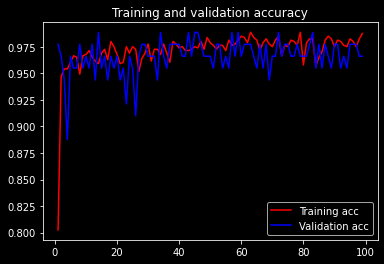

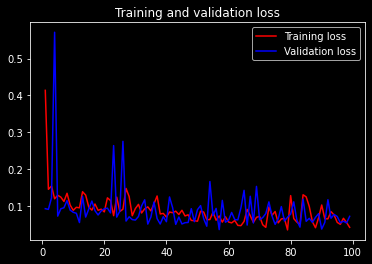

In [27]:
acc = CNN_model.history['accuracy']
val_acc = CNN_model.history['val_accuracy']
loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

## 9. Visualizando resultados e gerando previsões

In [28]:
score = CNN.evaluate(test_set)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

4/4 [==============================] - 6s 1s/step - loss: 0.1198 - accuracy: 0.9500
Test Loss: 0.11980465799570084
Test Accuracy: 0.949999988079071


In [29]:
y_pred = CNN.predict(test_set)
y_pred = np.round(y_pred)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        71
           1       0.88      0.97      0.92        29

    accuracy                           0.95       100
   macro avg       0.93      0.95      0.94       100
weighted avg       0.95      0.95      0.95       100



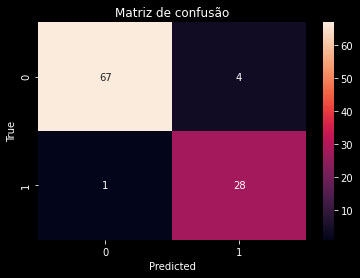

In [31]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
plt.title("Matriz de confusão")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()